In [62]:
from vae_model import train_vae_with_params
from data_preparation import load_and_prepare_data
# --- Import des modules nécessaires ---
from vae_model import VAEModel, build_encoder_decoder
from data_preparation import load_and_prepare_data


In [63]:
import numpy as np
import pandas as pd
from simulate import SimuleTS
from visualisation import simulate_ts_report_flexible
from custom_score import evaluate_multiple_scenarios

In [64]:

# --- Paramètres connus ---
params = {
    "nVar": 2,
    "Lag": 4,
    "LagO": 44,
    "latent_dim": 10,
    "seasonFreq": [24, 8760],
    "nb_layers": 2,
    "activation": "relu",
    "units_encoder": 64,
    "units_decoder": 94
}

# --- Recréer l'encodeur et le décodeur ---
encoder, decoder = build_encoder_decoder(**params)

# --- Créer le modèle VAE ---
vae_model = VAEModel(
    encoder=encoder,
    decoder=decoder,
    n_season=len(params["seasonFreq"]),
    beta=0.02
)

# --- Charger les poids pré-entraînés ---
weights_path = r"C:\Users\d72085\Desktop\metocean_generative\Optimisation\vae_model_saved.h5"
vae_model.load_weights(weights_path)
print("Weights loaded successfully.")

# --- Préparer les données ---
X_train, Y_train, X_test, Y_test, Min_list, Max_list, fen = load_and_prepare_data(
    lag=params['Lag'],
    lag0=params['LagO']
)

Weights loaded successfully.


In [65]:
n_instances = Y_train.shape[0]  # 147176

# Reshape chaque prédiction (et vérité) en [instances, steps, variables]
Y_target_reshaped = Y_train.reshape(n_instances, params['LagO'], params['nVar'])

# On prend uniquement le premier time step de chaque prédiction (i.e. à t)
Y_true_full = Y_target_reshaped[:, 0, :]  # shape: (147176, 2)
Y_true_full.shape

(147187, 2)

In [66]:
# Min_list et Max_list sont de longueur 2 : [Min_wind, Min_wave]
Min_array = np.array(Min_list)
Max_array = np.array(Max_list)

# Dénormalisation
Y_true_real = 0.5 * (Y_true_full + 1) * (Max_array - Min_array) + Min_array

print("Shape Y_true_real:", Y_true_real.shape)

Shape Y_true_real: (147187, 2)


In [67]:
Sim_real, _ = SimuleTS(
    vae_model=vae_model,
    X_input=X_train,
    seasonFreq=params['seasonFreq'],
    Min_list=Min_list,
    Max_list=Max_list,
    nVar=params['nVar'],             
    GAUSSIAN_STD=1.0
)

▶ Trace CDFs pour l'instance sélectionnée


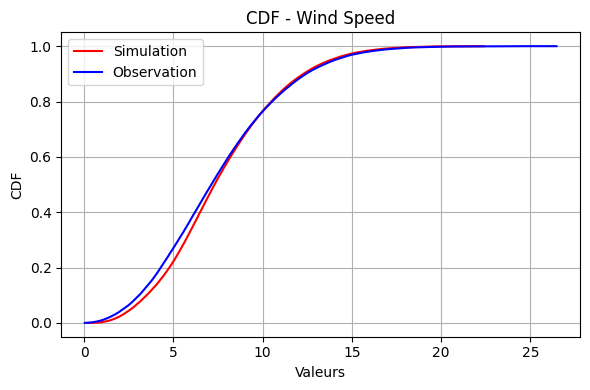

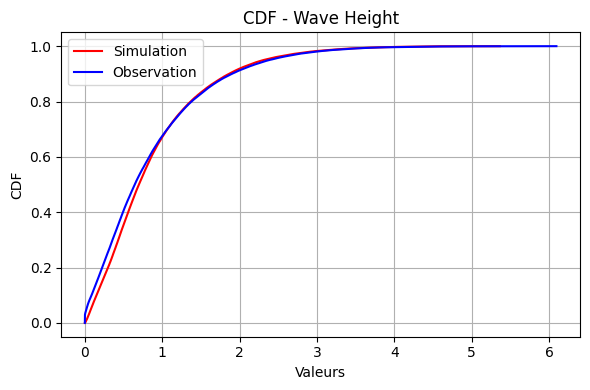

▶ Trace de la fonction de répartition (instance complète)
Nb fenêtres - Simulation: 2948, Observation: 3223
▶ Windows mois pour l'instance sélectionnée
Mois 01 — 226 fenêtres : [ 4 20 14 19  6  9  2  3  3 50 29  5  2  5 25  6 12  1  3 36 22 20  1 10
  6  5  7  4  4  3  3 16  3  9  5  6 13 25 11 17 22  2  3 17 12 24 10  4
 82 50  3 71 25  3 16 38  2  2 12 22  5  6  2  3  2  3  4  1  4  7 31 10
  6  6  7  3 17 36 26 10 16 13 19 24 27  9 15 21 18 13 31 42  3 11  2 61
 26  5 10  5 37 33  3 18  5 11 68 15  5  1 22  7 43 13 12  5  4 17  6  6
 14  4 13  4 24  4 21  1  8  5  6 38  5 10  3 20 28 43  7  3 11  1 52 57
  8 42 10  6  2  1  8 14 34 55  3 57 24  4  7 39  5 56 21  7  8  4 55  3
 96  6 36  4 10 14  8 11 25 23 22 76  1  8  7  6  4 16 22  5  4 21  8 13
 53 35  3 22  8  5 11 41 13  8 15 12  2  4  2  9 37 27 11 14  5  8  9  5
  5  2 27 10 13 17  8  1  4  3]
Mois 02 — 229 fenêtres : [ 1 15 11 46 41 27 21  7 30 85  8 40 35  6 11  4  3 12 47  5  3 11  6  2
  6  7  3 48 27  9  4 11  1 29  6 11

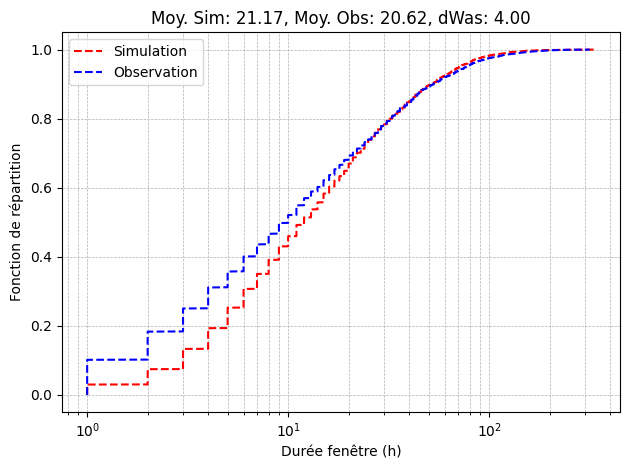

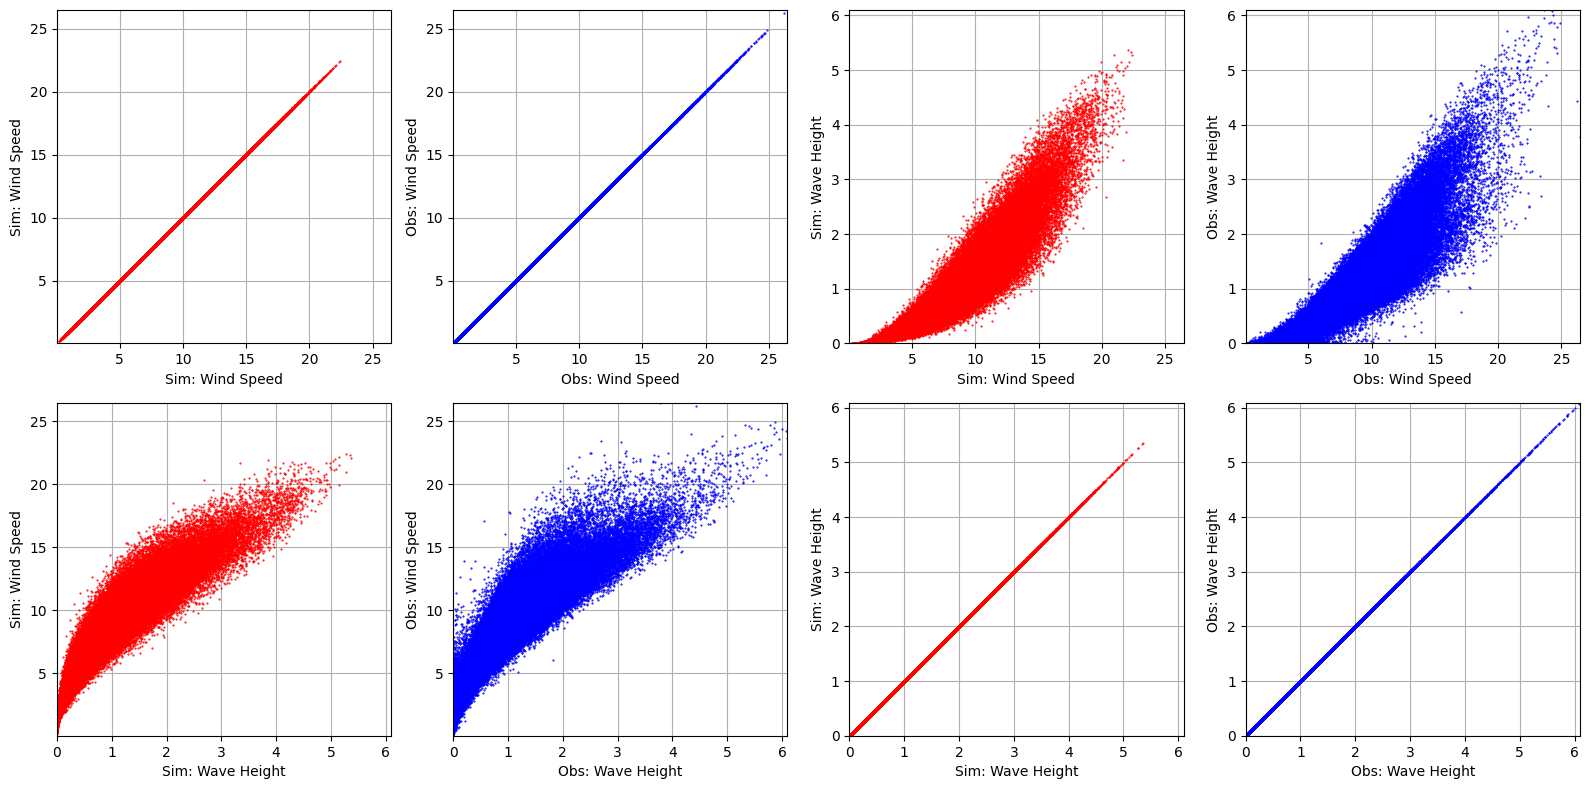

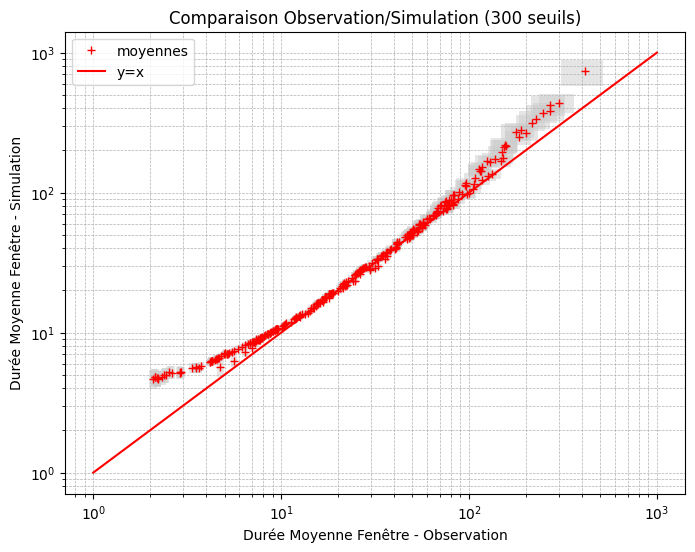

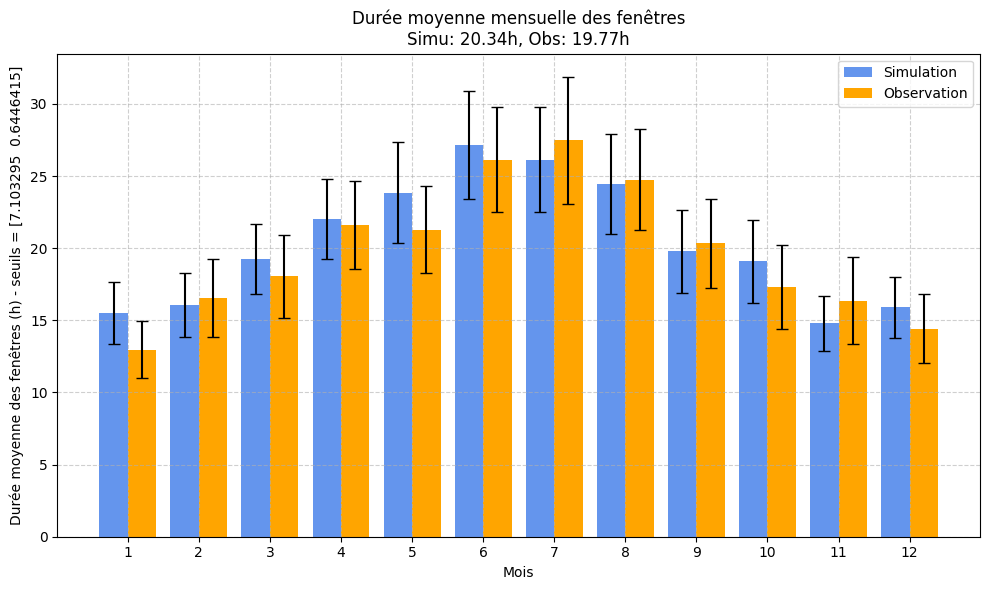

Rapport terminé.


In [7]:
simulate_ts_report_flexible(Y_true_real, Sim_real, fen=fen)

In [68]:
df_scores = evaluate_multiple_scenarios(
        vae_model=vae_model,
        X_input_test=X_test,
        Y_target_test=Y_test,
        seasonFreq=params['seasonFreq'],
        Min_list=Min_list,
        Max_list=Max_list,
        nVar=params['nVar'],
        fen=fen,
        n_scenarios=1,
        GAUSSIAN_STD=1.0
    )
if "score_global" in df_scores.columns:
   print("Mean score_global:", df_scores["score_global"].mean())

Mean score_global: 0.7614696109373735


In [69]:
simulated_series_list = df_scores["simulated_series"].tolist()
n_scenarios = len(simulated_series_list)
N, nVar = simulated_series_list[0].shape
scenarios_pred1 = np.array(simulated_series_list).reshape(n_scenarios, N, nVar)
scenarios_pred1.shape

(1, 36797, 2)

In [41]:
from visualisation import plot_scenarios_with_range

In [ ]:


Y_target_real = np.empty_like(Y_test)

for i in range(nVar):
    idx = np.arange(i, Y_test.shape[1], nVar)
    Y_target_real[:, idx] = 0.5 * (Y_test[:, idx] + 1) * (Max_list[i] - Min_list[i]) + Min_list[i]

Obs_full_list = []
for i, row in enumerate(Y_target_real):
    seq = row.reshape(params['LagO'], nVar)
    if i == 0:
        Obs_full_list.extend(seq.tolist())
    else:
        Obs_full_list.append(seq[-1].tolist())
Obs_full = np.array(Obs_full_list)

# Tracer les séries réelles et simulées
plot_scenarios_with_range(Obs_full, scenarios_pred, start=0, end=3000)

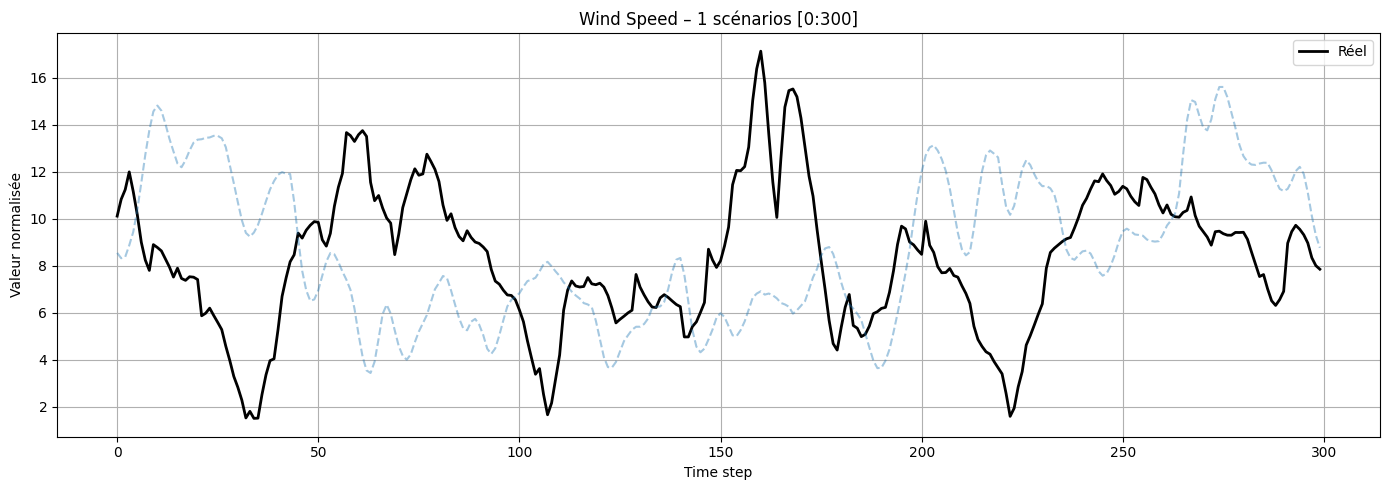

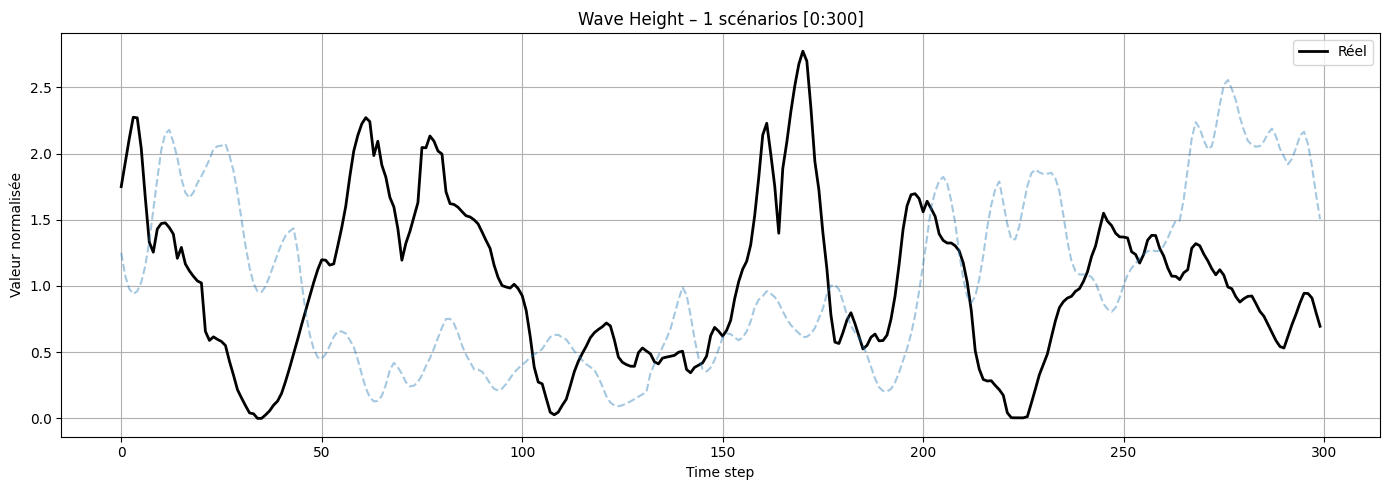

In [70]:
plot_scenarios_with_range(Obs_full, scenarios_pred1, start=0, end=300)

In [29]:
df_scores

scenario_id                                   simulated_series  \
0            0  [[8.551554, 1.2485291], [8.323856, 1.0779132],...   

   score_global  distribution  fenetre_ks  saisonnalite  variabilite  \
0       0.76147      0.806399    0.854132      0.678009     0.488457   

   correlation_inter  
0           0.980351

# GAN

In [45]:
from simulate_gan import SimuleTS
from visualisation import simulate_ts_report_flexible
from data_preparation import load_and_prepare_data
from GAN_model import CGAN_WGANGP, build_generator_critic

In [46]:

# --- Paramètres optimaux du GAN ---
params = {
    "nVar": 2,
    "Lag": 8,
    "LagO": 47,
    "seasonFreq": [24, 8760],
    "z_dim": 32,
    "nb_layers": 3,
    "activation": "leakyrelu",
    "units_gen": 256,
    "units_disc": 256
}

# --- Recréer le générateur et le critique ---
G, D = build_generator_critic(**params)

# --- Créer le modèle GAN ---
gan_model = CGAN_WGANGP(
    generator=G,
    critic=D,
    seasonFreq=params["seasonFreq"],
    gp_weight=10.0,
    n_critic=5,
    l1_weight=10.0,
    z_dim=params["z_dim"],
    z_std=1.0
)

# --- Charger les poids pré-entraînés ---
weights_path = r"C:\Users\d72085\Desktop\metocean_generative\Optimisation\gan_model_saved.h5"
gan_model.load_weights(weights_path)
print("GAN weights loaded successfully.")


GAN weights loaded successfully.


Shape Y_true_real: (147176, 2)
▶ Trace CDFs pour l'instance sélectionnée


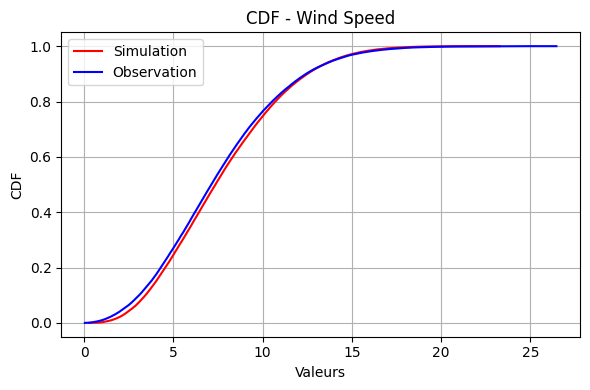

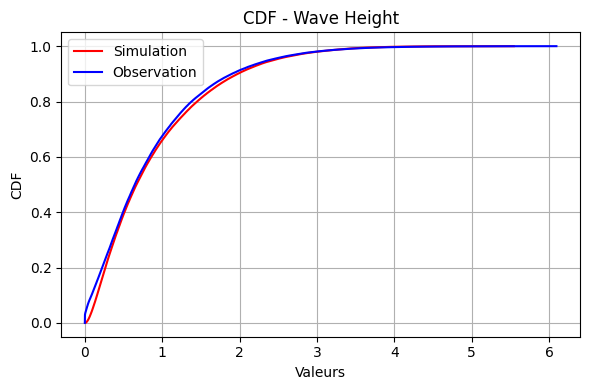

▶ Trace de la fonction de répartition (instance complète)
Nb fenêtres - Simulation: 3530, Observation: 3223
▶ Windows mois pour l'instance sélectionnée
Mois 01 — 281 fenêtres : [ 4  7  8  1  5  2  7 10  7 17  5 12  5 10 32 23  1 11  2  1 11  1 58 28
  3 10 16  3  5 29  6 36  6  3  1  4  1 17  1  1  5 18  7  1 41 15  9 10
  8 16 34  1  8  5 20  2 25  9  9 18  1 24  7  4 10  9 11  6  6  9  3 20
  2  4  7 12  7 26  2 12 19 31  4 58  1  2  1 10 20 16 20 10 21 13 13  6
 14  1  3  1 44  5 61  5 41 10 27  6 30  3  3 49 78  1  2 11  2  1 15  5
  8 20  9  5  3  5  5  1  3  1  6 17  9 40  5  7  3 41  1  4  4 16  1 51
  1 35  1 11 29 17  6  6 37  1 14 19  1  8  1 46  3  1  7 15 17  2 27  1
  9  1  1  1  1  2  8  8 11 27 14  3  3 12 23  3  8 38  1 25  7  8  1 13
 20 24  5  9 12  3 41  1  1  6 21  6  1  4  2 10  1  4  2 10 34  1  1 14
  2 13  3  3 12  7  6 16  1 33  6 12  6 41  1  3  1 11  8  4  4  1  3 11
  5 15 19  1  1  9 15  4  4  8 53  1 47 17 17  7 13  8  1 12 12 18  2  2
 42  1  8 15  4  1 1

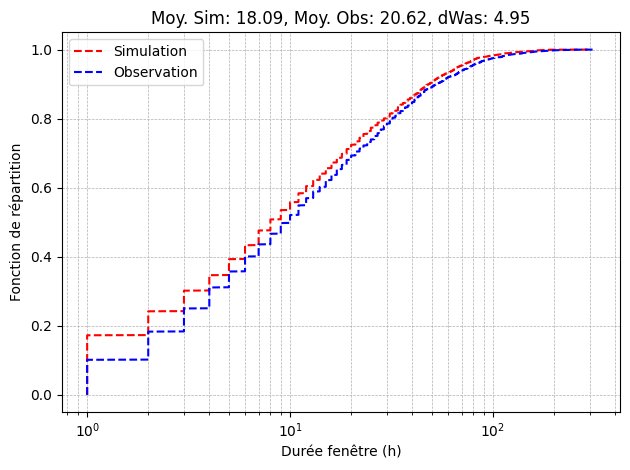

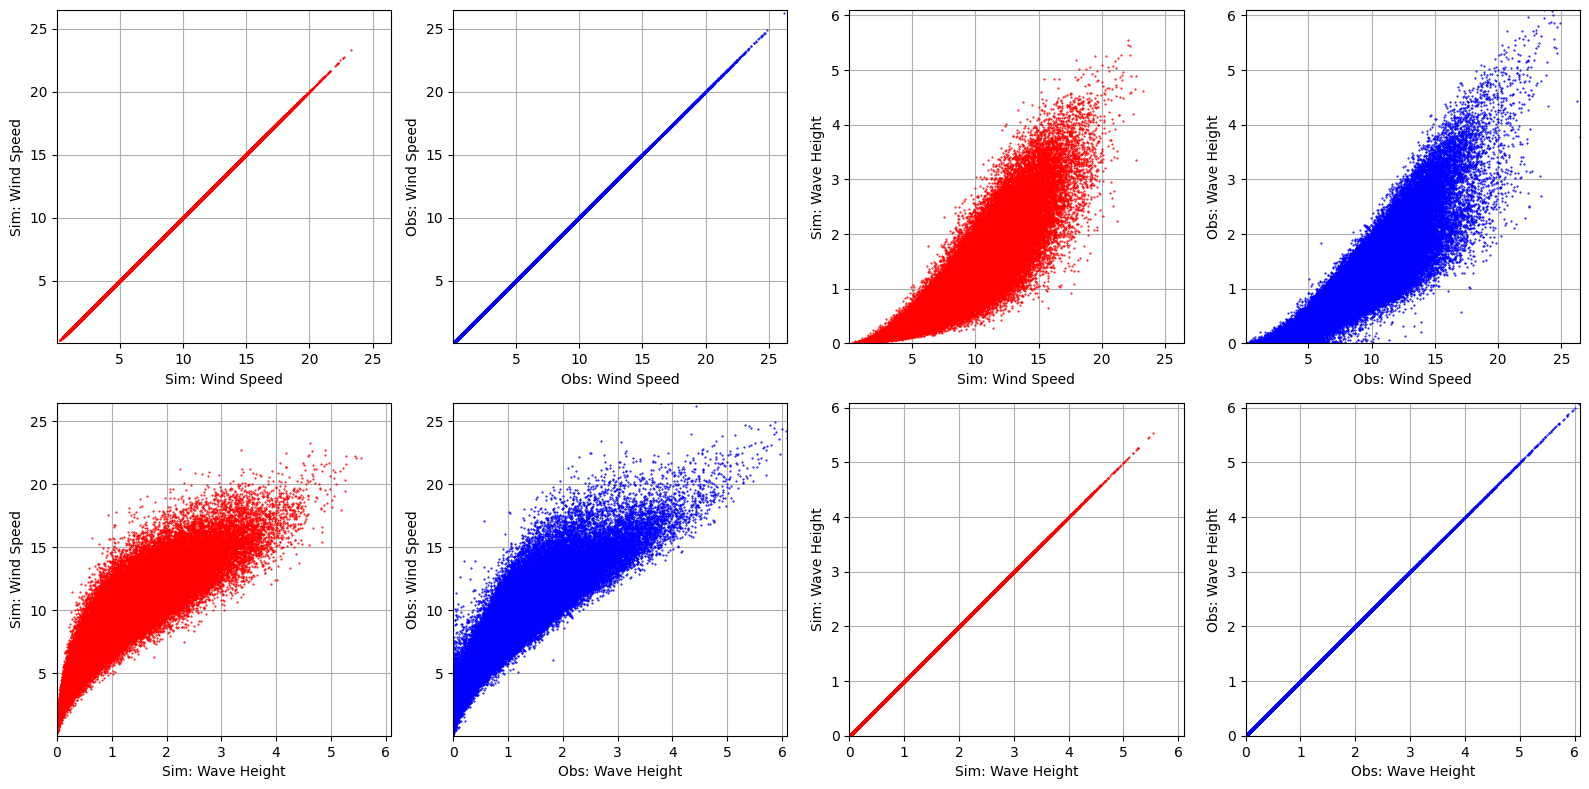

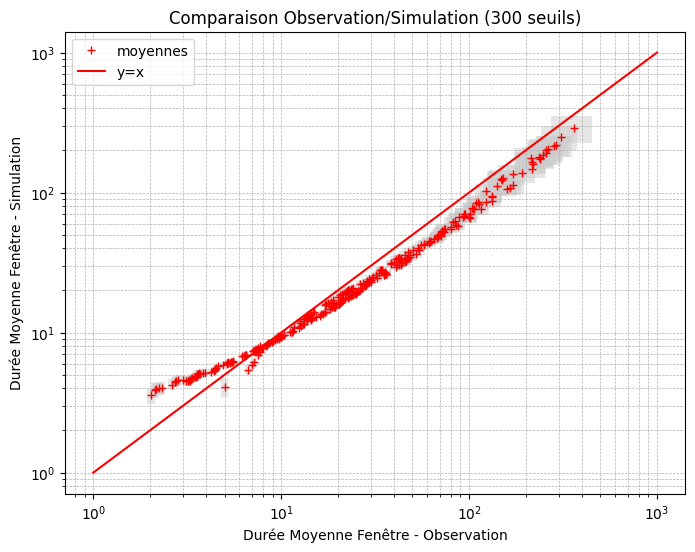

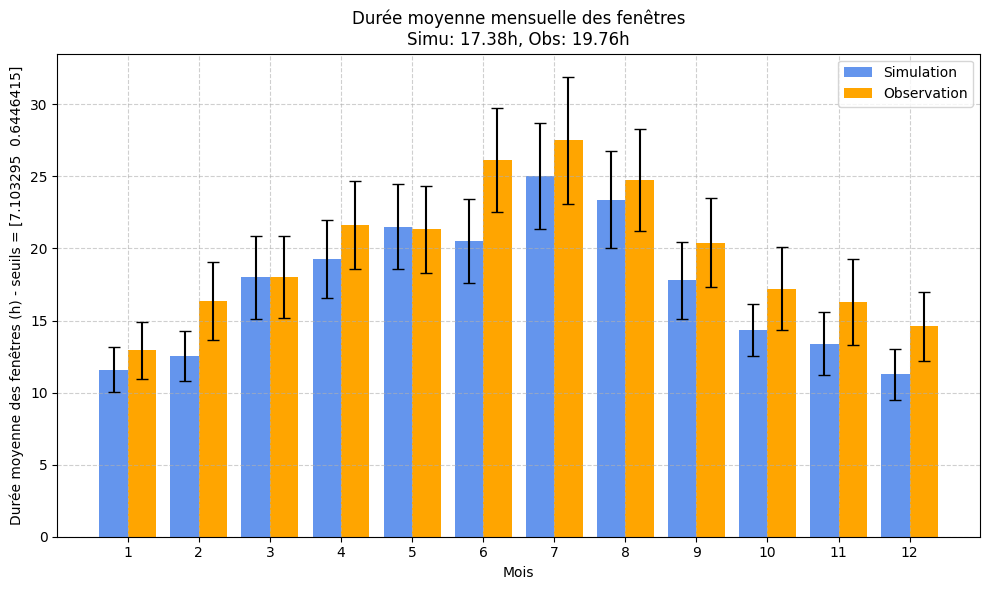

Rapport terminé.


In [47]:

# --- Préparer les données ---
X_train, Y_train, X_test, Y_test, Min_list, Max_list, fen = load_and_prepare_data(
    lag=params['Lag'],
    lag0=params['LagO']
)

# --- Dénormalisation des observations ---
n_instances = Y_train.shape[0]
Y_target_reshaped = Y_train.reshape(n_instances, params['LagO'], params['nVar'])
Y_true_full = Y_target_reshaped[:, 0, :]
Min_array = np.array(Min_list)
Max_array = np.array(Max_list)
Y_true_real = 0.5 * (Y_true_full + 1) * (Max_array - Min_array) + Min_array

print("Shape Y_true_real:", Y_true_real.shape)

# --- Simulation GAN ---
Sim_real, _ = SimuleTS(
    gan_model=gan_model,
    X_input=X_train,
    seasonFreq=params['seasonFreq'],
    Min_list=Min_list,
    Max_list=Max_list,
    nVar=params['nVar'],
    GAUSSIAN_STD=1.0
)

# --- Visualisation comparative ---
simulate_ts_report_flexible(Y_true_real, Sim_real, fen=fen)

In [54]:
from custom_score_gan import evaluate_multiple_scenarios
df_scores = evaluate_multiple_scenarios(
            gan_model=gan_model,  # simulate_gan.py utilise sample_forecast
            X_input_test=X_test,
            Y_target_test=Y_test,
            seasonFreq=params['seasonFreq'],
            Min_list=Min_list,
            Max_list=Max_list,
            nVar=params['nVar'],
            fen=fen,
            n_scenarios=1,
            GAUSSIAN_STD=params.get('z_std', 1.0)
        )

In [55]:
if "score_global" in df_scores.columns:
   print("Mean score_global:", df_scores["score_global"].mean())

Mean score_global: 0.8104565541564989


In [56]:
df_scores

scenario_id                                   simulated_series  \
0            0  [[11.005404, 1.7364141], [12.555793, 1.9026048...   

   score_global  distribution  fenetre_ks  saisonnalite  variabilite  \
0      0.810457      0.822458    0.915513       0.72852     0.589145   

   correlation_inter  
0           0.996647

In [57]:

# Extraction des séries simulées
simulated_series_list = df_scores["simulated_series"].tolist()
n_scenarios = len(simulated_series_list)
N, nVar = simulated_series_list[0].shape
scenarios_pred = np.array(simulated_series_list).reshape(n_scenarios, N, nVar)
scenarios_pred.shape

(1, 36794, 2)

In [58]:
Y_test.shape[1]

94

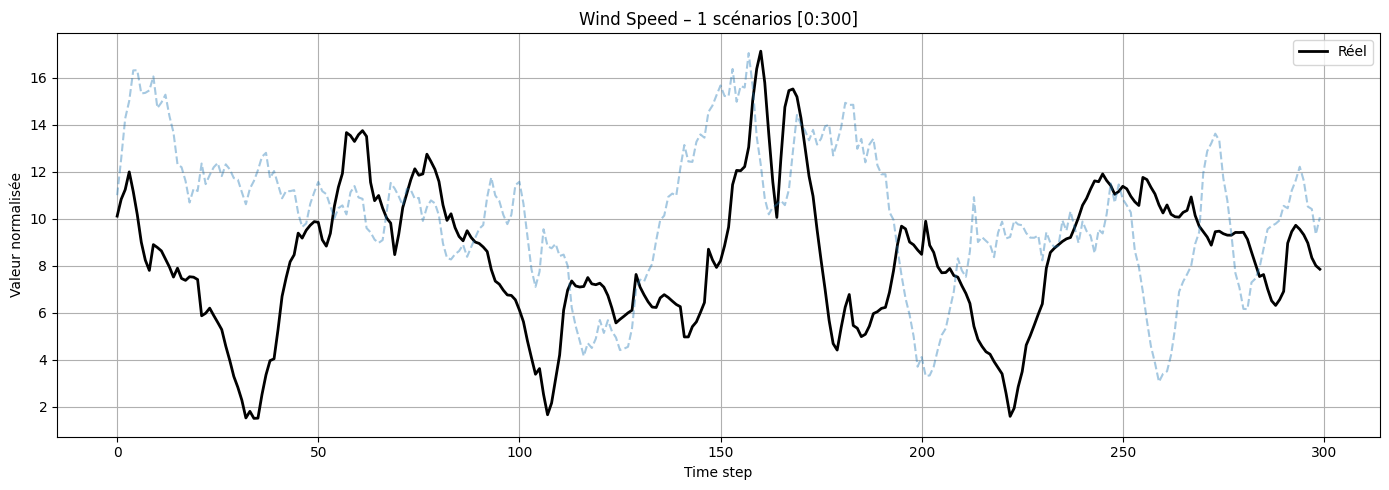

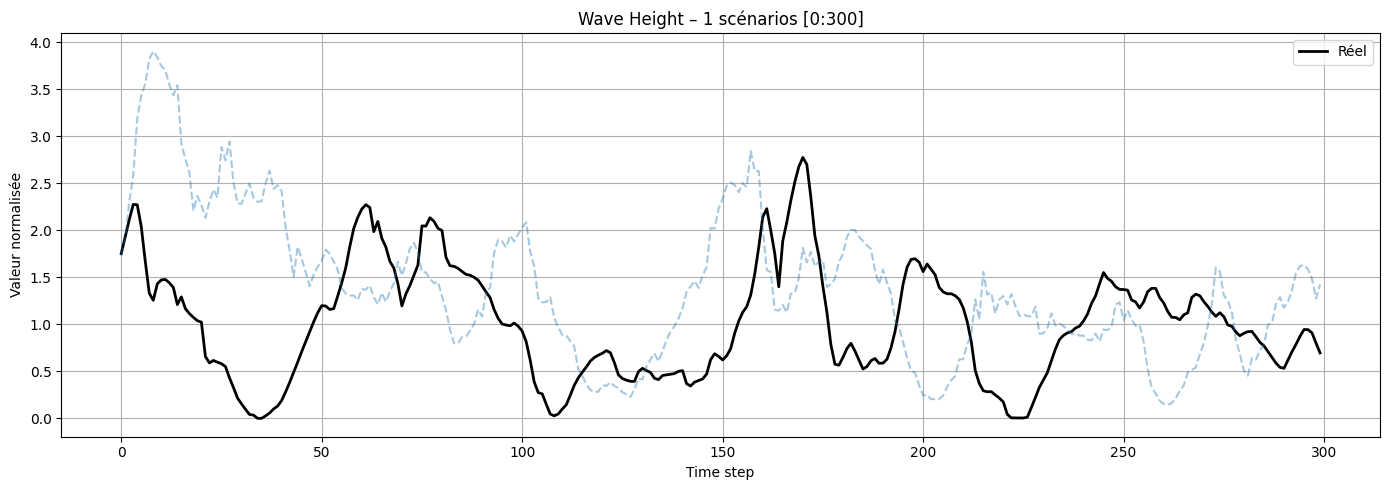

In [59]:
from visualisation import plot_scenarios_with_range

Y_target_real = np.empty_like(Y_test)

for i in range(nVar):
    idx = np.arange(i, Y_test.shape[1], nVar)
    Y_target_real[:, idx] = 0.5 * (Y_test[:, idx] + 1) * (Max_list[i] - Min_list[i]) + Min_list[i]

Obs_full_list = []
for i, row in enumerate(Y_target_real):
    seq = row.reshape(params['LagO'], nVar)
    if i == 0:
        Obs_full_list.extend(seq.tolist())
    else:
        Obs_full_list.append(seq[-1].tolist())
Obs_full = np.array(Obs_full_list)

# Tracer les séries réelles et simulées
plot_scenarios_with_range(Obs_full, scenarios_pred, start=0, end=300)


# Architecture 2 (CVAE)

In [39]:
# === Paramètres NOMAD ===
params = {
    "beta": 5e-05,                # beta fixé
    "latent_dim": 10,             # dimension latente
    "nb_layers": 2,               # nombre de couches
    "activation": "relu",         # fonction d'activation
    "optimizer_name": "rmsprop",  # optimiseur
    "learning_rate": 1e-5,        # 10^-5
    "units_encoder": 74,          # unités encoder
    "units_decoder": 114,         # unités decoder
    "batch_size": 32,             # batch size
    "Lag": 13,                    # lag
    "LagO": 32,                   # lag0
    "epochs": 40,                 # nombre d'epochs
    "seasonFreq": [24, 8760],     # fréquence saisonnière (fixe)
    "nVar": 2                     # nombre de variables (fixe dans tes données)
}

# Charger les données
X_train, Y_train, X_test, Y_test, Min_list, Max_list, fen = load_and_prepare_data(
    lag=params["Lag"],
    lag0=params["LagO"]
)

# Entraîner le modèle avec les paramètres
vae, history = train_vae_with_params(
    X_train, Y_train,
    X_test, Y_test,
    params
)


Training with params: {'beta': 5e-05, 'latent_dim': 10, 'nb_layers': 2, 'activation': 'relu', 'optimizer_name': 'rmsprop', 'learning_rate': 1e-05, 'units_encoder': 74, 'units_decoder': 114, 'batch_size': 32, 'Lag': 13, 'LagO': 32, 'epochs': 40, 'seasonFreq': [24, 8760], 'nVar': 2}
Epoch 1/40
4600/4600 - 17s - 4ms/step - kl_loss: 81.1647 - loss: 0.0959 - reconstruction_loss: 0.0959 - val_kl_loss: 156.5912 - val_loss: 0.0203 - val_reconstruction_loss: 0.0203
Epoch 2/40
4600/4600 - 14s - 3ms/step - kl_loss: 189.3744 - loss: 0.0169 - reconstruction_loss: 0.0163 - val_kl_loss: 218.7170 - val_loss: 0.0125 - val_reconstruction_loss: 0.0118
Epoch 3/40
4600/4600 - 14s - 3ms/step - kl_loss: 213.9900 - loss: 0.0119 - reconstruction_loss: 0.0105 - val_kl_loss: 212.2642 - val_loss: 0.0103 - val_reconstruction_loss: 0.0089
Epoch 4/40
4600/4600 - 14s - 3ms/step - kl_loss: 192.8267 - loss: 0.0104 - reconstruction_loss: 0.0085 - val_kl_loss: 181.7274 - val_loss: 0.0095 - val_reconstruction_loss: 0.0077

KeyboardInterrupt: 

In [ ]:
Sim_real, _ = SimuleTS(
    vae_model=vae,
    X_input=X_train,
    seasonFreq=params['seasonFreq'],
    Min_list=Min_list,
    Max_list=Max_list,
    nVar=params['nVar'],             
    GAUSSIAN_STD=1.0
)

In [ ]:
n_instances = Y_train.shape[0] 

# Reshape chaque prédiction (et vérité) en [instances, steps, variables]
Y_target_reshaped = Y_train.reshape(n_instances, params['LagO'], params['nVar'])

# On prend uniquement le premier time step de chaque prédiction (i.e. à t)
Y_true_full = Y_target_reshaped[:, 0, :]  # shape: (147176, 2)

# Min_list et Max_list sont de longueur 2 : [Min_wind, Min_wave]
Min_array = np.array(Min_list)
Max_array = np.array(Max_list)

# Dénormalisation
Y_true_real = 0.5 * (Y_true_full + 1) * (Max_array - Min_array) + Min_array

print("Shape Y_true_real:", Y_true_real.shape)

Shape Y_true_real: (147192, 2)


▶ Trace CDFs pour l'instance sélectionnée


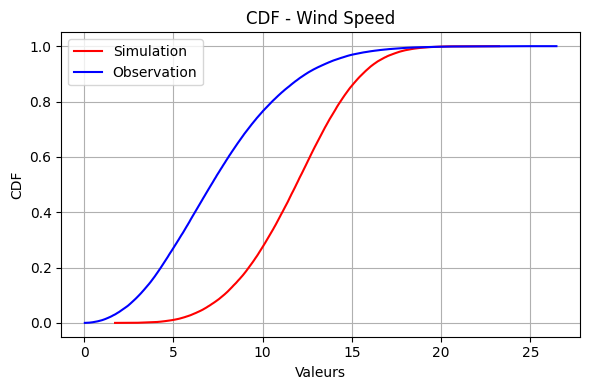

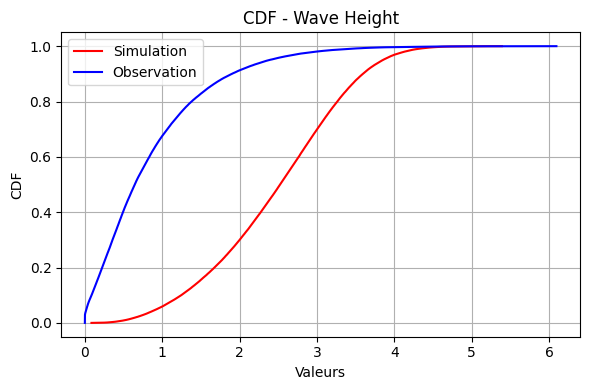

▶ Trace de la fonction de répartition (instance complète)
Nb fenêtres - Simulation: 740, Observation: 3223
▶ Windows mois pour l'instance sélectionnée
Mois 01 — 34 fenêtres : [ 1  6  1 15  1 14 13  3  3 14 10  1 10  1  1  1  1  1  4  1  3  1 19  1
  1  1  1  1  1  1  1  2  1  1]
Mois 02 — 31 fenêtres : [10  3  7  5  1  2  1  2  1  1  1  1  1  4  8  1  1  6  4  6  1  6  1  4
 22  1  2  1  1  6  4]
Mois 03 — 70 fenêtres : [ 8  3  2  1  2  1  1  2  2  1  3  1  1  1  2  1  5  1  2  3  2  1  2  1
  8  9  5  1  3  1  3  2  9  6  1  6  4  1  2  2  1  2 10  1  1  7  1  5
  1  1  1  6  1 12  1  1  6  1 17  1  1  1  1  4 12  4  1 14  1  1]
Mois 04 — 64 fenêtres : [14  6  2 14  3  1  3  1  1  2 12 18  3  1  1  2  1  1  1  1  1  1  1  1
  1  2  1  1 11  1  9  1  1  1  1  4  1  1  3  1  2  1  2  5  1 33  1  1
  1  1  2  1  1  1  1  3  3  1  1  1  1  1  1  1]
Mois 05 — 94 fenêtres : [ 1  1  2  2  1  1  8  5  1  1  1  2  3  2  1  4  1  1  1  1  1  1  3  1
  1  3  1  1  2  1  5  1  6  9  1  1  1  6 16

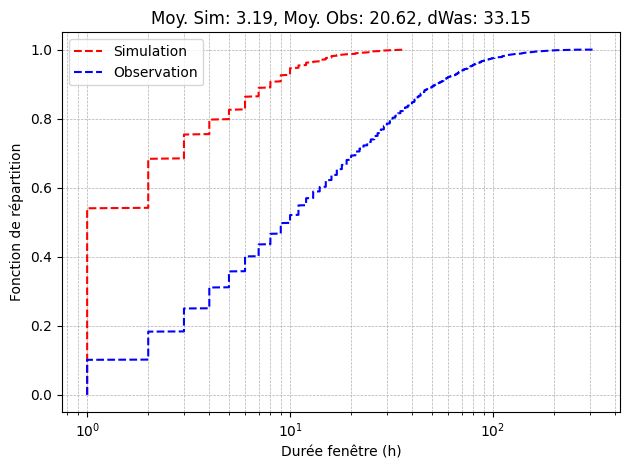

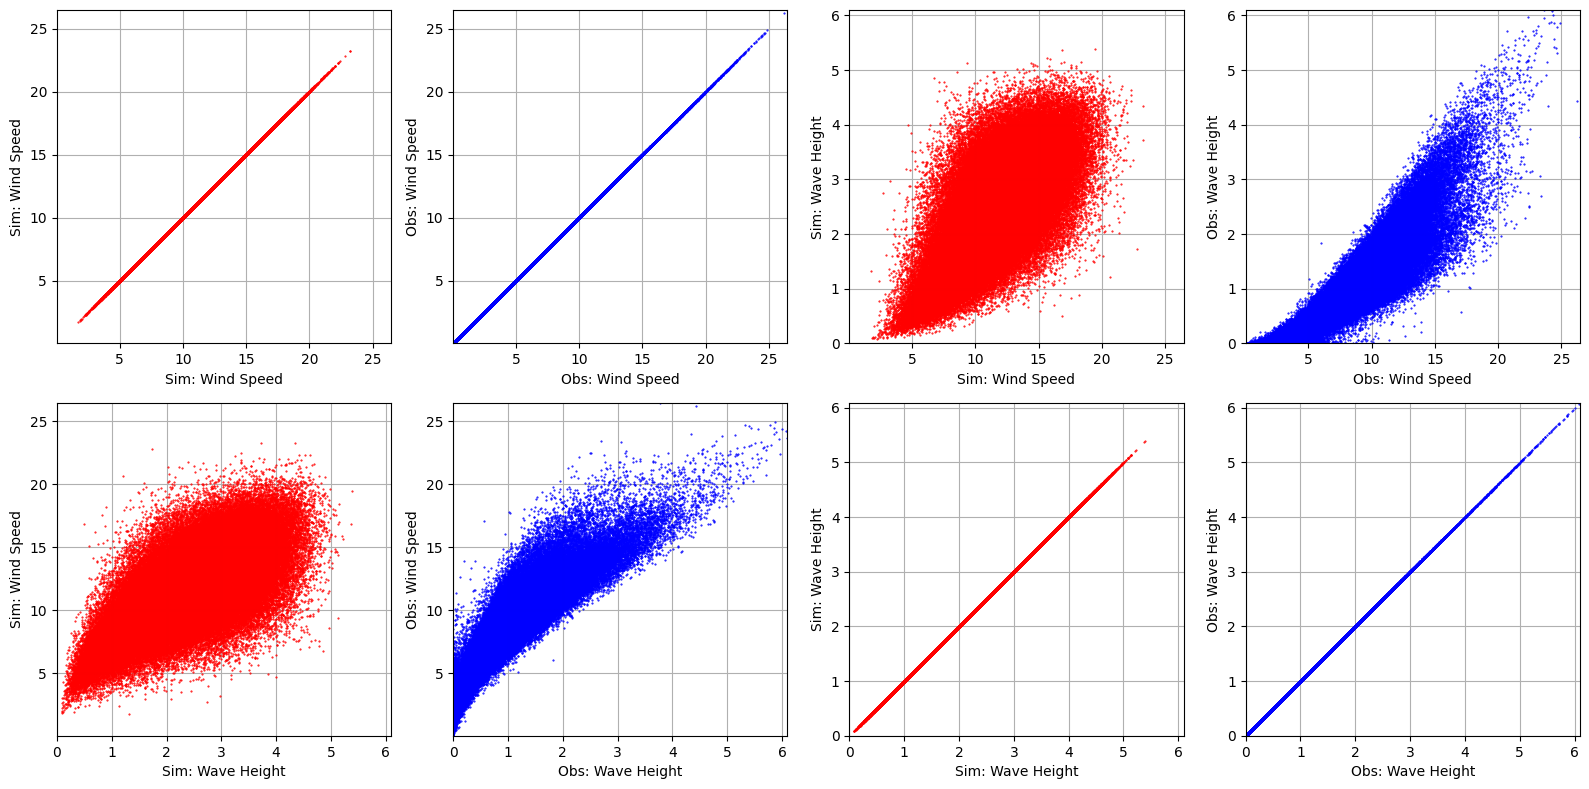

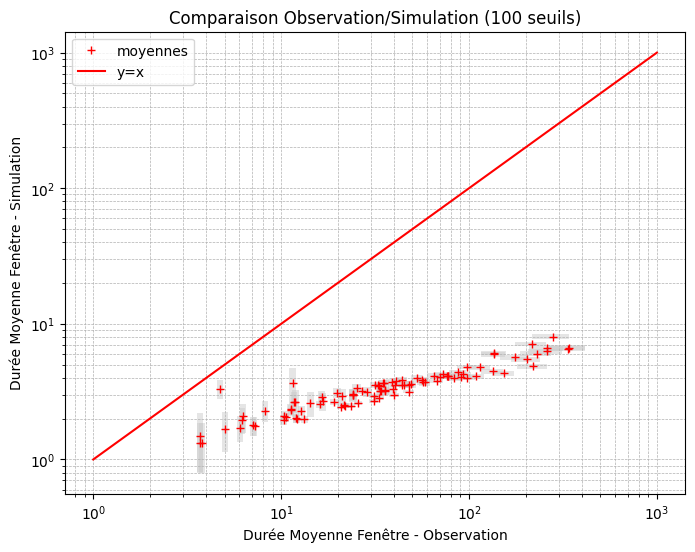

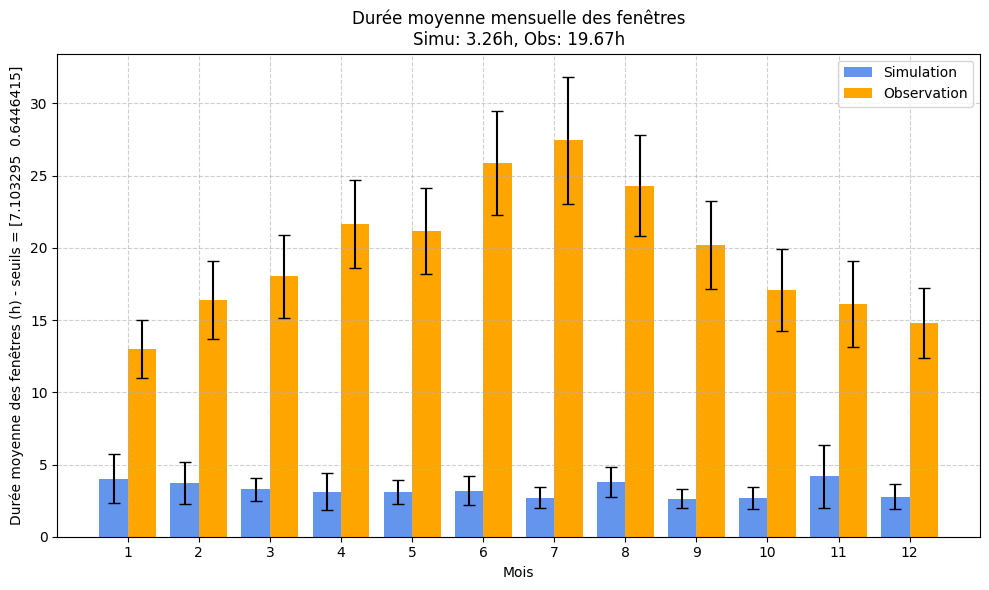

Rapport terminé.


In [ ]:
simulate_ts_report_flexible(Y_true_real, Sim_real, fen=fen)

In [ ]:
df_scores = evaluate_multiple_scenarios(
        vae_model=vae,
        X_input_test=X_test,
        Y_target_test=Y_test,
        seasonFreq=params['seasonFreq'],
        Min_list=Min_list,
        Max_list=Max_list,
        nVar=params['nVar'],
        fen=fen,
        n_scenarios=1,
        GAUSSIAN_STD=1.0
    )
if "score_global" in df_scores.columns:
   print("Mean score_global:", df_scores["score_global"].mean())

Mean score_global: 0.403877535228933


# Architecture de Base (CVAE)

In [ ]:
params_base = {
    "beta": 0.0099,              # valeur initiale beta dans ton VAEModel
    "latent_dim": 12,             # Latency = 12 → Latent_dim implicite
    "nb_layers": 2,               # nombre de couches dans l’encodeur et le décodeur
    "activation": "leakyrelu",   # tu utilises LeakyReLU
    "optimizer_name": "adam",     # optimiseur
    "learning_rate": 1e-3,        # learning rate
    "units_encoder": 300,         # unités encoder Dense(300 * nVar)
    "units_decoder": 512,         # unités decoder (première Dense)
    "batch_size": 312,            # batch_size
    "Lag": 8,                     # Lag
    "LagO": 47,                   # LagO
    "epochs": 40,                 # nombre d’epochs
    "seasonFreq": [24, 8760],     # fréquence saisonnière
    "nVar": 2                      # nombre de variables
}

# Charger les données
X_train, Y_train, X_test, Y_test, Min_list, Max_list, fen = load_and_prepare_data(
    lag=params_base["Lag"],
    lag0=params_base["LagO"]
)

# Entraîner le modèle avec les paramètres
vae, history = train_vae_with_params(
    X_train, Y_train,
    X_test, Y_test,
    params_base
)

Training with params: {'beta': 0.0099, 'latent_dim': 12, 'nb_layers': 2, 'activation': 'leakyrelu', 'optimizer_name': 'adam', 'learning_rate': 0.001, 'units_encoder': 300, 'units_decoder': 512, 'batch_size': 312, 'Lag': 8, 'LagO': 47, 'epochs': 40, 'seasonFreq': [24, 8760], 'nVar': 2}
Epoch 1/40
472/472 - 6s - 14ms/step - kl_loss: 261.4473 - loss: 0.0082 - reconstruction_loss: 0.0082 - val_kl_loss: 280.8466 - val_loss: 0.0018 - val_reconstruction_loss: 0.0018
Epoch 2/40
472/472 - 5s - 10ms/step - kl_loss: 166.4254 - loss: 0.0020 - reconstruction_loss: 0.0015 - val_kl_loss: 156.0119 - val_loss: 0.0018 - val_reconstruction_loss: 0.0013
Epoch 3/40
472/472 - 5s - 11ms/step - kl_loss: 133.6914 - loss: 0.0021 - reconstruction_loss: 0.0012 - val_kl_loss: 125.6925 - val_loss: 0.0019 - val_reconstruction_loss: 0.0010
Epoch 4/40
472/472 - 5s - 10ms/step - kl_loss: 108.2776 - loss: 0.0022 - reconstruction_loss: 0.0011 - val_kl_loss: 100.0765 - val_loss: 0.0020 - val_reconstruction_loss: 9.9744e-0

In [ ]:
Sim_real, _ = SimuleTS(
    vae_model=vae,
    X_input=X_train,
    seasonFreq=params_base['seasonFreq'],
    Min_list=Min_list,
    Max_list=Max_list,
    nVar=params_base['nVar'],             
    GAUSSIAN_STD=1.0
)

In [ ]:
n_instances = Y_train.shape[0] 

# Reshape chaque prédiction (et vérité) en [instances, steps, variables]
Y_target_reshaped = Y_train.reshape(n_instances, params_base['LagO'], params_base['nVar'])

# On prend uniquement le premier time step de chaque prédiction (i.e. à t)
Y_true_full = Y_target_reshaped[:, 0, :]  # shape: (147176, 2)

# Min_list et Max_list sont de longueur 2 : [Min_wind, Min_wave]
Min_array = np.array(Min_list)
Max_array = np.array(Max_list)

# Dénormalisation
Y_true_real = 0.5 * (Y_true_full + 1) * (Max_array - Min_array) + Min_array

print("Shape Y_true_real:", Y_true_real.shape)

Shape Y_true_real: (147176, 2)


▶ Trace CDFs pour l'instance sélectionnée


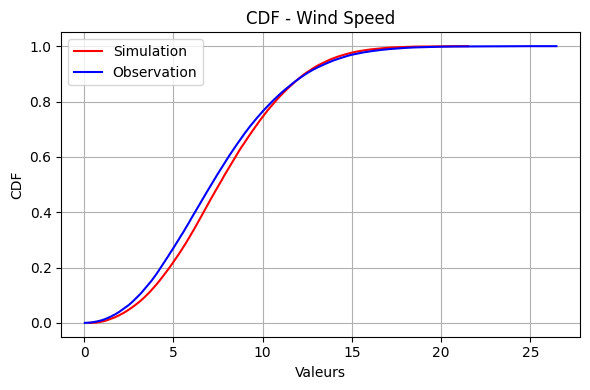

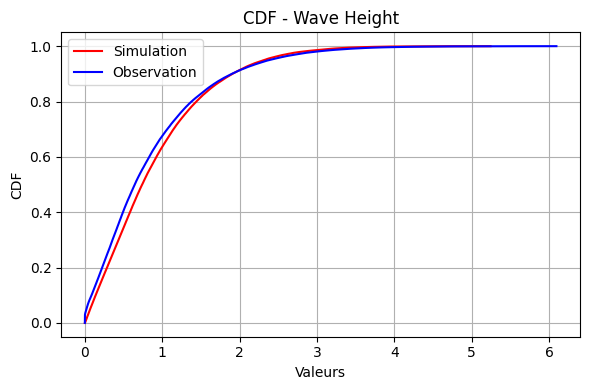

▶ Trace de la fonction de répartition (instance complète)
Nb fenêtres - Simulation: 2594, Observation: 3223
▶ Windows mois pour l'instance sélectionnée
Mois 01 — 223 fenêtres : [ 4  2  2 11  4 16 57 11  1 10  7 16 18 31  4 35 31  6  1 15 25 35  3 22
  4  5 23  3 11 17  4 10  6 49 18  4 11 40  6  9 30 16  4 18  2  9 19 35
  6 18 21 26  7 12  1  6  6  3 16 13 33 56 22  3  2  4  6  9 23  2 11  9
 15  8 15 45  9  5 10  6 32 34  6 16 21  8  5  7 36 25  4 37 28  7 27  1
 22  6 65 10 45 43  2  4 13  7  6  3 38  9 32  8  7 13 15  4 27 10 17 15
 12  3 25 10  9  6 39  2 26 38 28  2  4  4 27  7  9  7  4  9  9 30  3 21
  4 12 34 40 12 10 15  5 22  3  6 17 31  7 35 12 14  6  4  7 14  5 12 82
  6 13  4 13  7 22 30  6 11 33 31  8  7 71 13 28  7  7  8  3  3 29 98 14
 10 20  5  5  8  7 60 11 33  2  2  9 27  9  6  8  8  8  7 15 11  1 24 20
 10  3 12 15  6 26 26]
Mois 02 — 196 fenêtres : [ 12   8  30   6 103   3   7  11   2  21  21  60   3  13  29  11  65  10
  44  17  19  12  13  22  17  13  13  15  10 

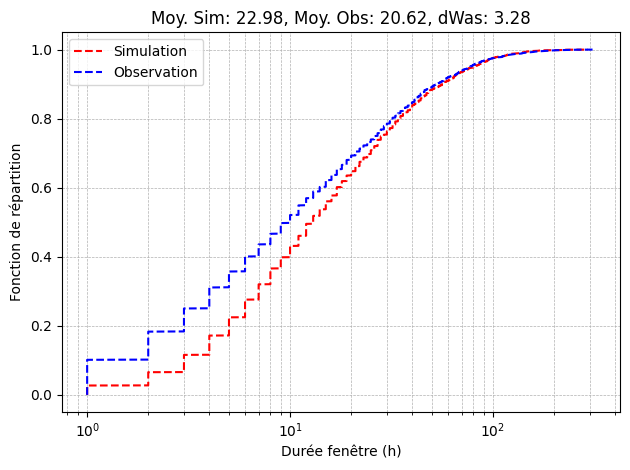

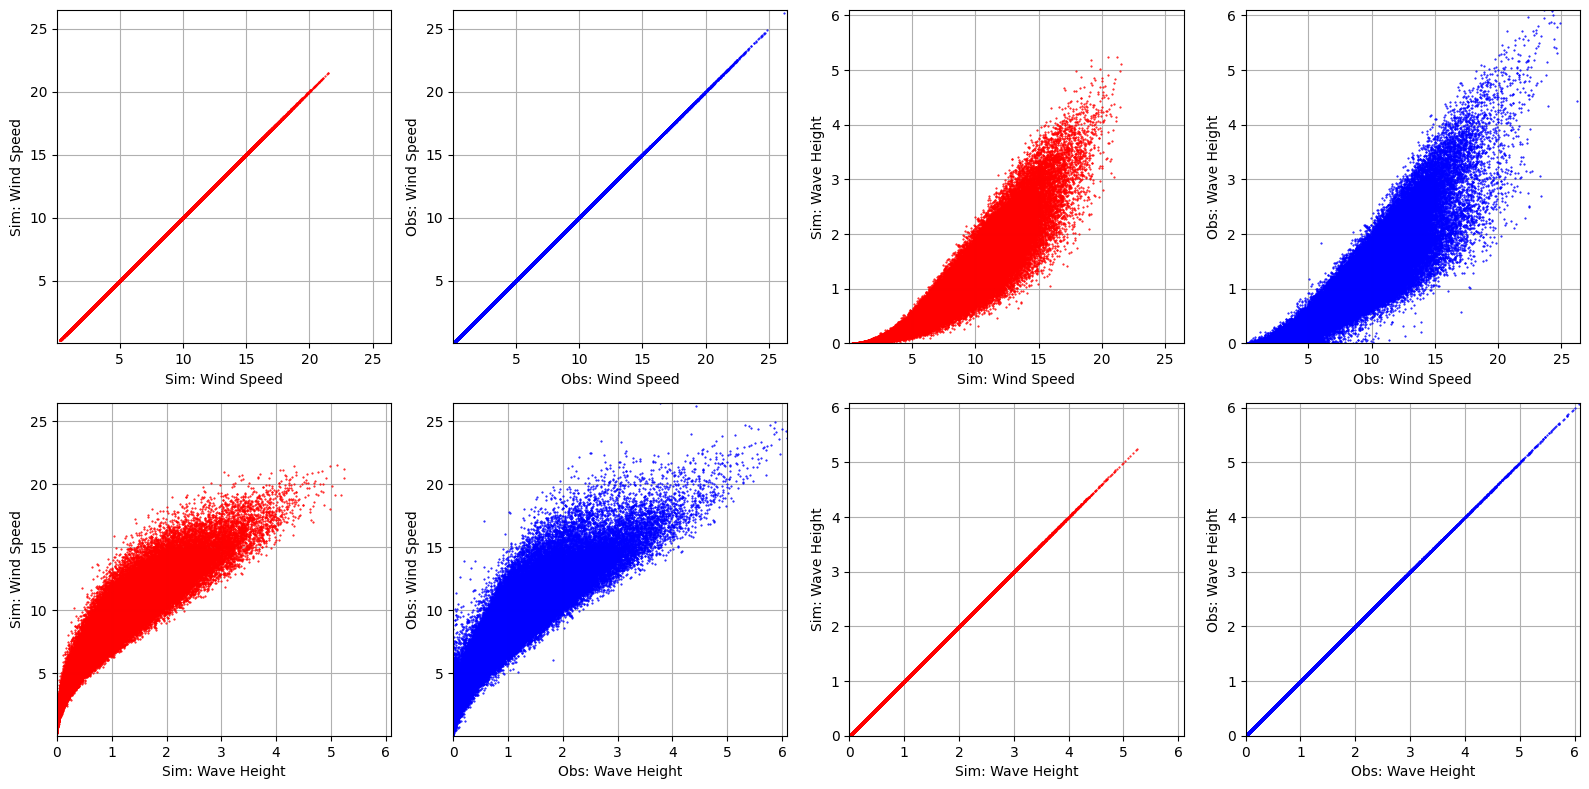

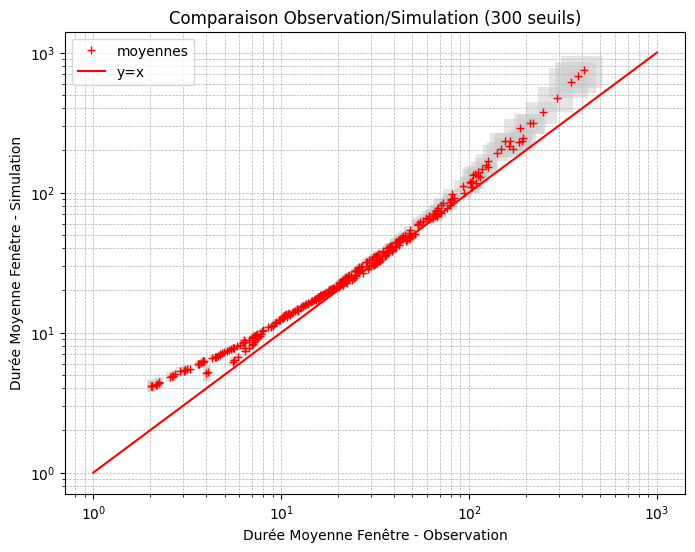

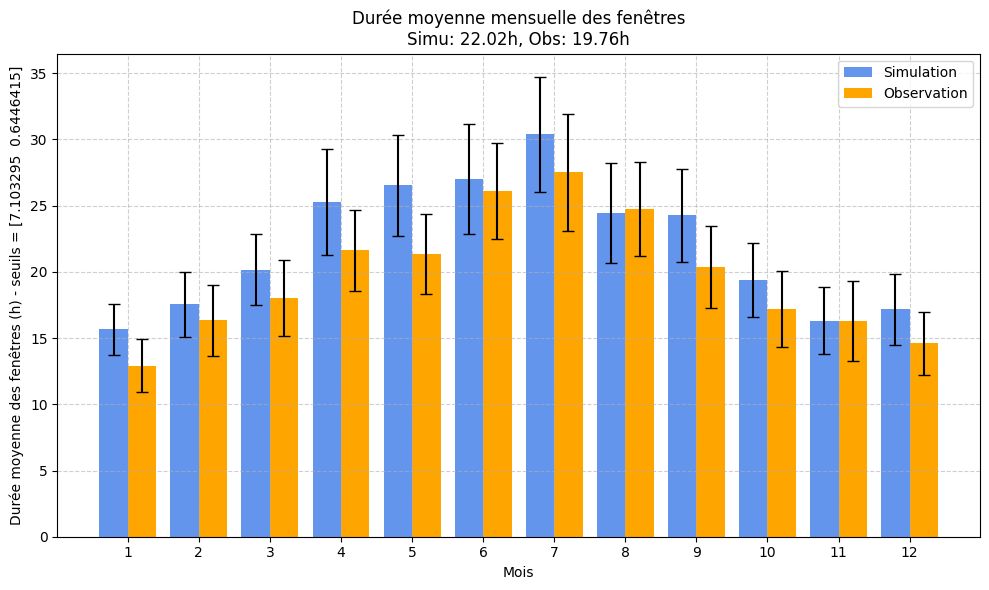

Rapport terminé.


In [ ]:
simulate_ts_report_flexible(Y_true_real, Sim_real, fen=fen)

In [ ]:
df_scores = evaluate_multiple_scenarios(
        vae_model=vae,
        X_input_test=X_test,
        Y_target_test=Y_test,
        seasonFreq=params['seasonFreq'],
        Min_list=Min_list,
        Max_list=Max_list,
        nVar=params['nVar'],
        fen=fen,
        n_scenarios=1,
        GAUSSIAN_STD=1.0
    )
if "score_global" in df_scores.columns:
   print("Mean score_global:", df_scores["score_global"].mean())

Mean score_global: 0.7557276443373312


In [73]:
df_scores

scenario_id                                   simulated_series  \
0            0  [[8.551554, 1.2485291], [8.323856, 1.0779132],...   

   score_global  distribution  fenetre_ks  saisonnalite  variabilite  \
0       0.76147      0.806399    0.854132      0.678009     0.488457   

   correlation_inter  
0           0.980351